In [1]:
import numpy as np
import pandas as pd
from mcspace.utils import pickle_load, pickle_save
import matplotlib.pyplot as plt
import seaborn as sns
from mcspace.data_utils import get_human_timeseries_dataset, get_mouse_diet_perturbations_dataset
import scipy
from scipy.stats import nbinom
import statsmodels.api as sm
from pathlib import Path 

# Paths

In [2]:
rootpath = Path("../../../../")
datapath = rootpath / "datasets"

basepath = Path("./")

# Load data

In [3]:
reads, num_otus, times, subjects, dataset = get_mouse_diet_perturbations_dataset(rootpath=datapath)

/home/gary/PROJECTS-wsl/MCSPACE_revisions/MCSPACE/mcspace/dataset.py:23: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  self._long_data = pd.read_csv(reads, compression='gzip')


In [4]:
print(times)
print(subjects)

[10 18 35 43 57 65 76]
['JX07' 'JX08' 'JX10']


# Fit negbin

In [5]:
# flatten data
def combine_samples(reads):
    times = list(reads.keys())
    subjs = list(reads[times[0]].keys())
    combreads = []
    for t in times:
        for s in subjs:
            combreads.append(reads[t][s])
    allreads = np.concatenate(combreads, axis=0)    
    return allreads


counts = combine_samples(reads)
print(counts.shape)

(56848, 74)


In [6]:
# get median number of particles per sample
def get_median_particles_per_sample(reads):
    times = list(reads.keys())
    subjs = list(reads[times[0]].keys())
    num_particles = []
    for t in times:
        for s in subjs:
            num_particles.append(reads[t][s].shape[0])
    return np.median(num_particles)

median_particles = get_median_particles_per_sample(reads)
print(f"Median number of particles per sample: {median_particles}")

Median number of particles per sample: 2829.0


In [7]:
rdepth = counts.sum(axis=1)
X = np.ones_like(rdepth)
res = sm.NegativeBinomial(rdepth,X).fit(start_params=[1,1])
mu = np.exp(res.params[0])
p = 1/(1+mu*res.params[1])
n = mu*p/(1-p)

Optimization terminated successfully.
         Current function value: 8.325946
         Iterations: 20
         Function evaluations: 25
         Gradient evaluations: 25


In [8]:
print(p)
print(n)

0.0007266169748467039
1.1078951664022763


## Plot fit

250.0
10000.0


/tmp/ipykernel_26333/4045805231.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax=sns.distplot(rdepth, kde=False, norm_hist=True, label='Data')


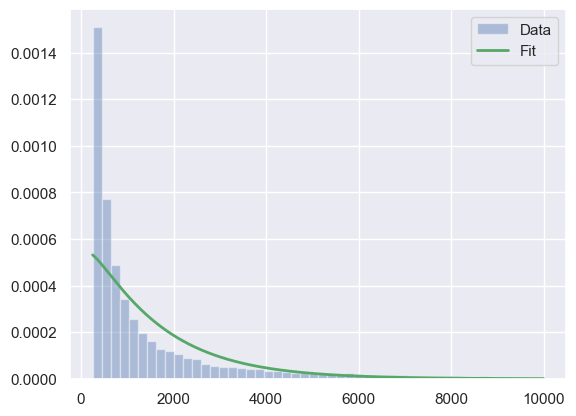

In [9]:
minr = np.amin(rdepth)
maxr = np.amax(rdepth)
print(minr)
print(maxr)

x_plot = np.linspace(minr,maxr,int(maxr-minr)+1)
sns.set_theme()
ax=sns.distplot(rdepth, kde=False, norm_hist=True, label='Data')
ax.plot(x_plot, nbinom.pmf(x_plot, n, p), 'g-', lw=2, label='Fit')
ax.legend()

In [10]:
median = np.median(rdepth)
iqr = np.percentile(rdepth, q=75) - np.percentile(rdepth, q=25) 

print(median)
print(iqr)

745.0
1390.0


# Save results

In [11]:
print(f"Negbin_n: {n}, Negbin_p: {p}")
print(f"Median: {median}, IQR: {iqr}")
print(f"Median particles per sample: {median_particles}")
print(f"Num OTUs: {num_otus}")

Negbin_n: 1.1078951664022763, Negbin_p: 0.0007266169748467039
Median: 745.0, IQR: 1390.0
Median particles per sample: 2829.0
Num OTUs: 74


In [13]:
pickle_save(basepath / "negbin_fit_params_Mouse_data.pkl", {'negbin_n': n, 'negbin_p': p, 'median': median, 'iqr': iqr,
                                                           "num_particles": median_particles, "num_otus": num_otus})